In [1]:
#create word2vectors from a dataset and analyze them to see a semantic similarity.
#my corpus was really small just a book with 79000 tokens, but I would recommend using Game of thrones or any other book which has a bigger corpus for better results.

In [2]:
#future is the missing compatibility layer between Python 2 and Python 3. 
#It allows you to use a single, clean Python 3.x-compatible codebase to 
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

In [3]:
#used for encoding words to vectors
import codecs
#finds all pathnames matching a pattern, like regex and it helps in searching through a large dataset in a faster way.
import glob
#log events for libraries
import logging
#used for concurrency, running multiple threads and having each thread run a different process, which makes the program run faster.
#one major reason is for eg: you have 4 cores in your CPU and you program uses only 1 core which slows down your processing, but by using Multiprocessing it divides the code in to all the 4 CPU to make processing faster.
import multiprocessing
#dealing with operating system , like a reading file, saving it or loading it after training the model.
import os
#used for pretty printing, human readable form
import pprint
#granular regular expressions
import re

In [4]:
%matplotlib inline

In [5]:
#natural language toolkit, if you have a sentence and you feed it in nltk, it will give you tokens for each word
#you can have part of speech tagging like is the word a noun, verb, adjective, pronoun etc.
import nltk
#word 2 vec library, created by google, its a generalised collection of words
import gensim.models.word2vec as w2v
#dimensionality reduction, suppose we have word vectors that is going to be multidimensional, like I have used 250 Dimensional word vectors
#this helps in converting it in to 2D, to visualize them in a 2D graph.
import sklearn.manifold
##imports numpy as np. Numpy is used for basic matrix multiplication, addition. 
import numpy as np
#plotting
import matplotlib.pyplot as plt
#for parsing the dataset
import pandas as pd
#for visualization of the dataset, mainly used while plotting the graph
import seaborn as sns

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
#Step 1: Process our data
#clean data, punkt is a pretrained tokeniser which tokenises our text
nltk.download("punkt")
#words like (and,the,an a) are removed from the corpus so that the vectors are more accurate. 
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     /home/adityasharma101993/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adityasharma101993/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
#gets all the book names matching the txt file
book_filenames = sorted(glob.glob("./*.txt"))

In [9]:
#print books
print("Found books:")
book_filenames

Found books:


['./J. D. Vance-Hillbilly Elegy-HarperCollins (2016).txt']

In [10]:
#initialize rawunicode , we'll add all text to this one big file in memory
corpus_raw = u""
#for each book, read it, open it in utf 8 format, utf 8 is the format reading from files and unicode for vectors
#add it to the raw corpus
#corpus raw is a unicode format and we want to convert it in UTF-8.
#codecs library reads book file format and make it in UTF readable format.
for book_filename in book_filenames:
    book_filename = book_filename.decode('unicode_escape').encode('UTF-8')
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "UTF-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading './J. D. Vance-Hillbilly Elegy-HarperCollins (2016).txt'...
Corpus is now 444038 characters long



In [11]:
#tokenizastion, saved the trained model here
#load nltk punk in to memory its a trained model loaded in a byte stream (pickle:file format which loads as a byte stream)
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
tokenizer

In [12]:
#tokenize into sentences
#tokenizer is pre trained that converts words in to tokens and type of tokens we want is sentences.
raw_sentences = tokenizer.tokenize(corpus_raw)
#raw_sentences

In [13]:
#convert sentences into list of words
#remove unecessary characters, split into words, no hyphens
#split into words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [14]:
#for each sentence we have initialize an empty sentence list and add sentences to it, sentences where each word is tokenized.
#we add all the words in the empty sentence list by calling the sentence_to_wordlist function we defined above and by passing the raw_sentences which are then cleaned and appended in to sentence list.
#we check if our raw_sentence is greater than zero or not which is self explanatory.
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [15]:
#print an example
print(raw_sentences[9])
print(sentence_to_wordlist(raw_sentences[9]))

So I didn’t write this book because I’ve accomplished something extraordinary.
[u'So', u'I', u'didn', u't', u'write', u'this', u'book', u'because', u'I', u've', u'accomplished', u'something', u'extraordinary']


In [16]:
#count tokens, each one being a sentence
#here we just calculate the sentences and store the count in token_count and print it.
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))
token_count
#for sentence in sentences:
#    print(sentence)

The book corpus contains 79,767 tokens


79767

In [17]:
#step 2 build our model, another one is Glove
#set of words can be generalised in to a set of vectors like masculine, bob, john, beard, moustache all belong to man category
# here we define hyperparameters for our model.
#we convert words in to vectors and create vectors of these vectors.
#once we have the vectors we can use them for 3 main tasks like Similarity, distance and Ranking (Like browse all scientific papers and rank them based on papers that have word "Dropout" maximum numbers of time).


# Dimensionality of the resulting word vectors.
#more dimensions mean more training time, more computationally complex, but more generalized and more accurate. 
num_features = 250

# Minimum word count threshold, smallest set of words we want to recognise when we convert words to vectors
min_word_count = 3

# Number of threads to run in parallel, more workers faster to train.
num_workers = multiprocessing.cpu_count()

# Context window length, size of what we are looking at a time or blocks of words we consider at a time.
context_size = 7

# Downsample setting for frequent words that we do not want our model to look at it again and again.
#rate 0 and 1e-5 is recommended.
#how often to use
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#It is a random generator which tells which part of the words to convert in to vectors.
# Seeds makes sure our model is deterministic and its good for for debugging.
seed = 1

In [18]:
#we use gensim library topic modelling, you give it a corpus like this and it will create a model, save it, load it and given some words that we in the corpus it will give how similar the words are and what does not match.
vance2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

vance2vec.build_vocab(sentences) # number of words in corpus after downsampling, loads corpus that we clean in to memory and print size of it.

vance2vec.train(sentences, total_examples=vance2vec.corpus_count, epochs=vance2vec.iter)

269094

In [19]:
print("Word2Vec vocabulary length:", len( vance2vec.wv.vocab))
vance2vec.wv.vocab

Word2Vec vocabulary length: 2937


{u'Preble': <gensim.models.keyedvectors.Vocab at 0x7f6244467d10>,
 u'resist': <gensim.models.keyedvectors.Vocab at 0x7f6244434290>,
 u'yellow': <gensim.models.keyedvectors.Vocab at 0x7f6244f13b50>,
 u'four': <gensim.models.keyedvectors.Vocab at 0x7f6244afbfd0>,
 u'sleep': <gensim.models.keyedvectors.Vocab at 0x7f6244429890>,
 u'hanging': <gensim.models.keyedvectors.Vocab at 0x7f624457b690>,
 u'mansion': <gensim.models.keyedvectors.Vocab at 0x7f62444ab650>,
 u'oldest': <gensim.models.keyedvectors.Vocab at 0x7f62444ab690>,
 u'saved': <gensim.models.keyedvectors.Vocab at 0x7f62444ab6d0>,
 u'Until': <gensim.models.keyedvectors.Vocab at 0x7f624457b790>,
 u'forget': <gensim.models.keyedvectors.Vocab at 0x7f624440e310>,
 u'relationships': <gensim.models.keyedvectors.Vocab at 0x7f62444ab710>,
 u'whose': <gensim.models.keyedvectors.Vocab at 0x7f6244467d90>,
 u'feeding': <gensim.models.keyedvectors.Vocab at 0x7f6244429950>,
 u'buddy': <gensim.models.keyedvectors.Vocab at 0x7f6244467dd0>,
 u'poor

In [20]:
#save model, when done training. To make use of it load it from memory.
if not os.path.exists("trained"):
    os.makedirs("trained")
vance2vec.save(os.path.join("trained", "vance2vec.w2v"))    

In [21]:
#load model from memory as told above.
vance2vec = w2v.Word2Vec.load(os.path.join("trained", "vance2vec.w2v"))

In [22]:
#squash dimensionality to 2
#https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
#tsne (t stochastic distributed neighbour embedding) : helps in converting the 250 D word vector in to a 2 D vector, it squashes the 250 D vector in to a 2 D vector.
#So that we can plot and view it
#You can also you Principal Component analysis which uses Singular Value Decomposition which is a generalization of eigendecomposition.
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [23]:
#put it all into a giant matrix
all_word_vectors_matrix = vance2vec.wv.syn0

In [24]:
#train t sne on 250 D vector
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [25]:
#plot point in 2d space, tsne not only squashes the 250 D vector in to a 2 D vector but also gives us the X,Y coordinates.
points = pd.DataFrame(
    [(word, coords[0], coords[1]) #for each word, coords[0] - x and coords [1] - y
        for word, coords in [(word, all_word_vectors_matrix_2d[vance2vec.wv.vocab[word].index])for word in vance2vec.wv.vocab]
    ],
    columns=["word", "x", "y"]
)

In [26]:
points.head(10)

,word,x,y
0,Preble,-7.143142,-6.731486
1,yellow,5.074415,6.931360
2,four,4.784101,-2.388078
3,sleep,-0.646919,7.719352
4,hanging,-2.767090,4.926879
5,mansion,9.647242,10.533927
6,oldest,-7.962599,-2.598339
7,saved,-3.441164,9.402968
8,Until,-2.830950,-8.879527
9,poorly,-6.724362,2.427103


In [27]:
#plot
sns.set_context("poster")

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


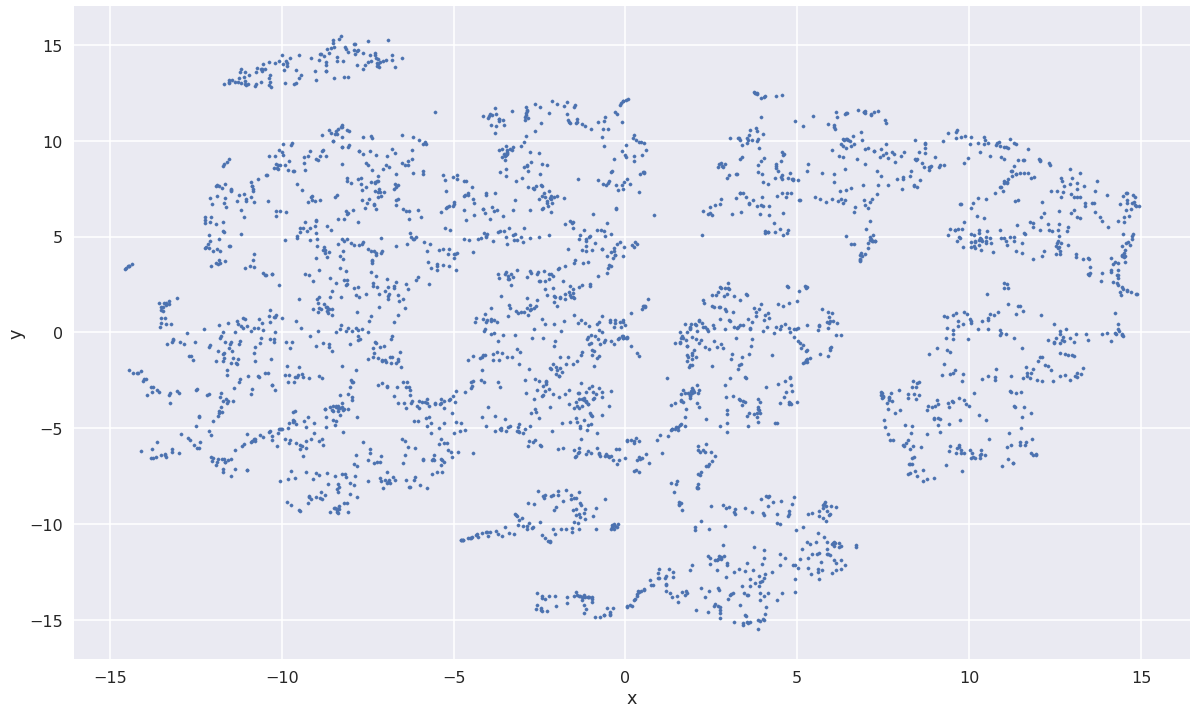

In [28]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))
#savefig('foo.png', bbox_inches='tight')

In [40]:
#here we zoom in to our 2937 vocab list and plot a graph of only some particular points not of whole corpus, which helps us in analysing the relation between the words as well accuray of our model.
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(20, 20))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)


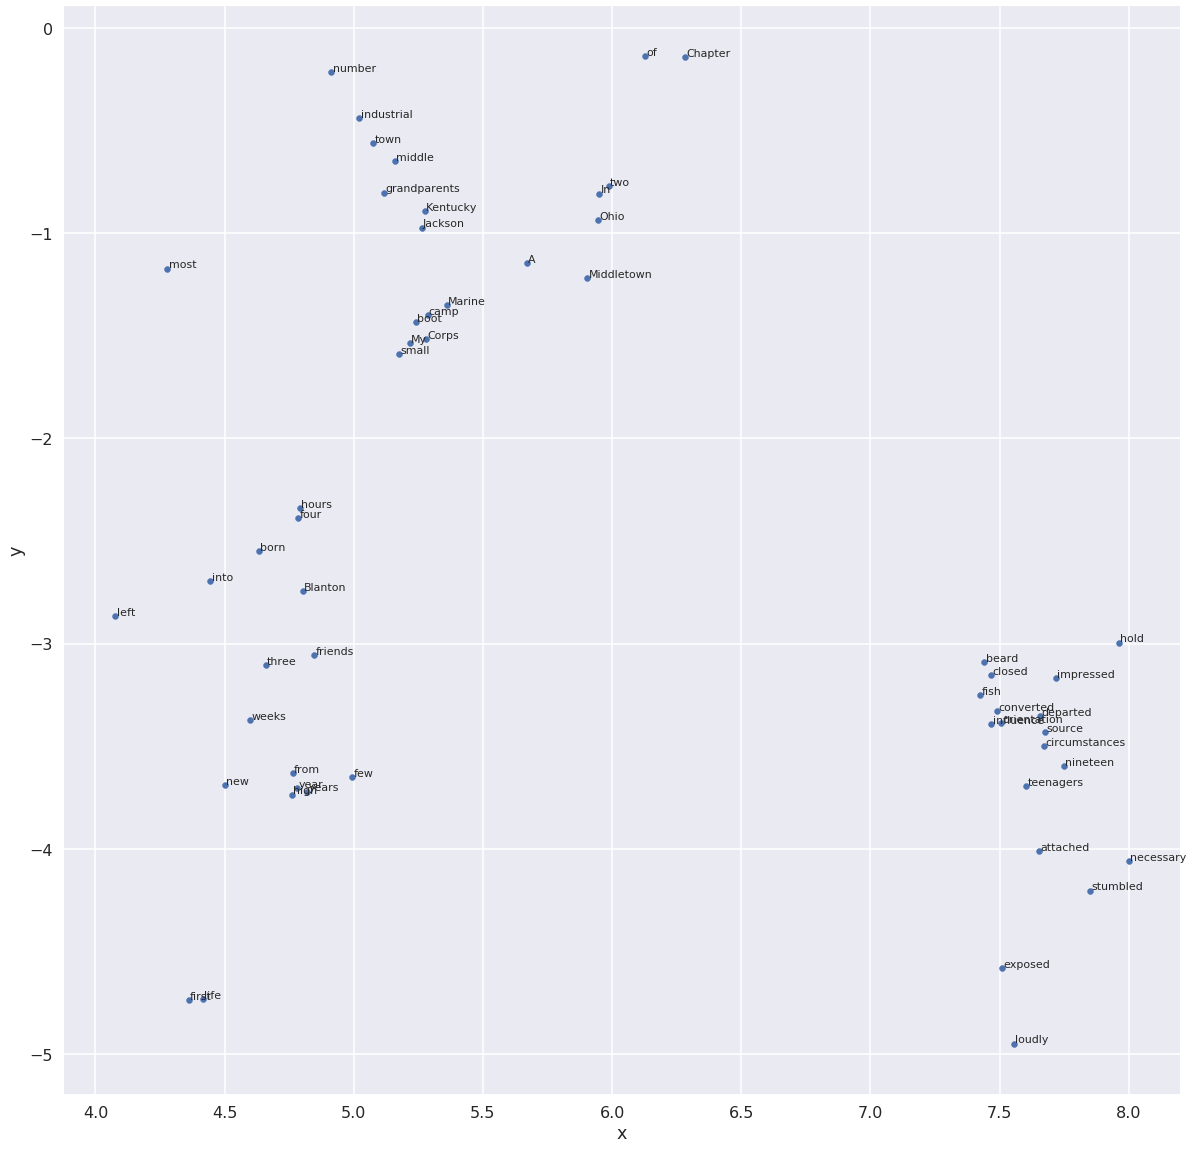

In [41]:
 plot_region(x_bounds=(4.0, 8.0), y_bounds=(-5.0, -0.1))
 #savefig('foo.png', bbox_inches='tight')

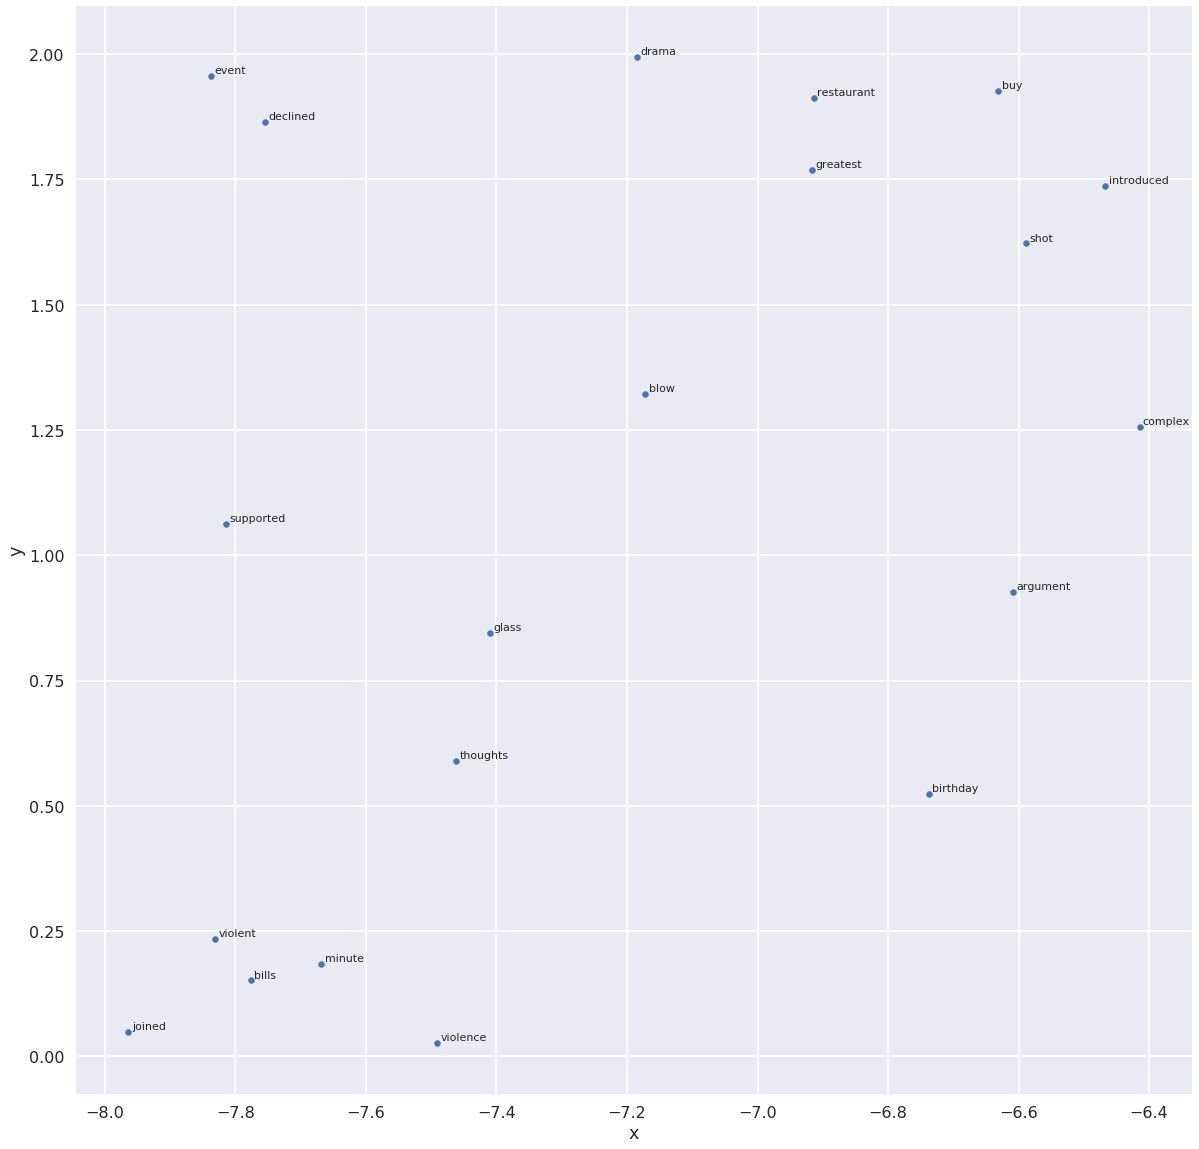

In [42]:
#here we plot the other region and similarly we can continue doing that to analyse our words in a 2 D space.
plot_region(x_bounds=(-8, -6), y_bounds=(0, 2))

In [45]:
#distance, similarity, and ranking
#here we use cosine similarity in which given 2 vectors we can do dot product divided by the magnitude of the vectors.
# which gives the relation like X is related to Y as B to A. It calculates the distance between X and Y and checks which is the similar distance to word A and gives B as output.
# we can also use Gaussian Similarity.
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = vance2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [47]:
nearest_similarity_cosmul("behavior", "discovered", "luck")
nearest_similarity_cosmul("join", "behavior", "wine")

behavior is related to discovered, as join is related to luck
join is related to behavior, as buy is related to wine


u'buy'

In [34]:
#here we print all those words which are closest to the word behavior in our corpus.
#similarly we can do this for other words as well.
vance2vec.most_similar("behavior")

[(u'discovered', 0.9996786117553711),
 (u'luck', 0.9996746778488159),
 (u'escaped', 0.9996725916862488),
 (u'join', 0.9996396899223328),
 (u'outbursts', 0.9996377825737),
 (u'besides', 0.9996333718299866),
 (u'resented', 0.9996326565742493),
 (u'confirmed', 0.9996284246444702),
 (u'possible', 0.9996159672737122),
 (u'abandoned', 0.9996116757392883)]

In [35]:
#this is the 250 D vector of a word "buddy" if you all remember I had used num_features as 250, hence my word vector is a 250 D vector.
vance2vec["buddy"]

array([ 0.00732826,  0.08045617, -0.02780399, -0.00628558, -0.08971362,
        0.021364  , -0.10642652, -0.00910826,  0.10571503,  0.09658644,
        0.00507233, -0.12170361, -0.08369555,  0.06931379,  0.06371297,
        0.1415377 , -0.11636707, -0.050169  ,  0.0172775 , -0.06573569,
       -0.08889465, -0.04446552,  0.10374736,  0.09466445,  0.09004969,
       -0.00183887, -0.04648966,  0.05312446, -0.08857759, -0.10370466,
       -0.19999348,  0.08111575, -0.07638516, -0.12125251,  0.06351001,
        0.13581271, -0.08935869,  0.18137616,  0.08340841, -0.02233252,
       -0.13122866,  0.07520718, -0.07717101, -0.04330318, -0.06828906,
       -0.10260015,  0.06868304,  0.01115204,  0.03073258,  0.04731694,
        0.14389935, -0.01214861, -0.02022189,  0.00513931, -0.07692604,
       -0.03142437,  0.10909666, -0.03152272, -0.11608743, -0.04884711,
       -0.05619696,  0.01899577,  0.13164325, -0.11958093,  0.0881418 ,
       -0.04616117, -0.09143205,  0.07678382,  0.19189356,  0.03